# Super Resolution Residual Network (SRResNet)

This notebook aims to reproduce the work of Ledig et. al (2017) with the DIV2K dataset.

Link to their arXiv paper:

[Photo-Realistic Single Image Super-Resolution Using a Generative Adversarial Network](https://arxiv.org/abs/1609.04802)

Link to DIV2K dataset:

[DIV2K dataset: DIVerse 2K resolution high quality images](https://data.vision.ee.ethz.ch/cvl/DIV2K/)

# 1 Import Libraries

In [1]:
import os
from collections import OrderedDict

from torch.utils.data import Dataset, DataLoader

import torch
from PIL import Image
import numpy as np
import torchvision.transforms as transforms

from torch.optim import SGD

from torch.utils.tensorboard import SummaryWriter

import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim

from tqdm import tqdm
from datetime import datetime

cuda_device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

torch.cuda.is_available()

False

# 2 Model Architecture

In [2]:
class SRResBlock(torch.nn.Module):
    def __init__(self, channels, kernel_size=3):
        super(SRResBlock, self).__init__()

        self.sub_block1 = torch.nn.Sequential(
            torch.nn.Conv2d(channels, channels, kernel_size=kernel_size, padding='same', stride=1),
            torch.nn.BatchNorm2d(channels),
            torch.nn.PReLU()
        )

        self.sub_block2 = torch.nn.Sequential(
            torch.nn.Conv2d(channels, channels, kernel_size=kernel_size, padding='same', stride=1),
            torch.nn.BatchNorm2d(channels)
        )

    def forward(self, x):
        residual = x
        x = self.sub_block1(x)
        x = self.sub_block2(x)

        return x + residual

class SRUpsampleBlock(torch.nn.Module):
    def __init__(self, channels, scale=2):
        super(SRUpsampleBlock, self).__init__()

        self.upsample = torch.nn.Sequential(
            torch.nn.Conv2d(channels, channels * (scale ** 2), kernel_size=3, padding='same', stride=1),
            torch.nn.PixelShuffle(scale),
            torch.nn.PReLU()
        )

    def forward(self, x):
        return self.upsample(x)
        
class SRResNet(torch.nn.Module):
    def __init__(self, in_out_channels=3, hidden_channel=64, kernel_sizes=(9, 3, 9), scale=4):
        super(SRResNet, self).__init__()

        self.block1 = torch.nn.Sequential(
            torch.nn.Conv2d(in_out_channels, hidden_channel, kernel_size=kernel_sizes[0], padding='same', stride=1),
            torch.nn.PReLU()
        )

        self.residual_blocks = torch.nn.Sequential(
            *[SRResBlock(channels=hidden_channel, kernel_size=kernel_sizes[1]) for _ in range(16)]
        )

        self.block2 = torch.nn.Sequential(
            torch.nn.Conv2d(hidden_channel, hidden_channel, kernel_size=kernel_sizes[1], padding='same', stride=1),
            torch.nn.BatchNorm2d(hidden_channel)
        )

        # Assuming scale of power of 2
        self.upsample_blocks = torch.nn.Sequential(
            *[SRUpsampleBlock(channels=hidden_channel, scale=2) for _ in range(int(np.log2(scale)))]
        )

        self.block3 = torch.nn.Sequential(
            torch.nn.Conv2d(hidden_channel, in_out_channels, kernel_size=kernel_sizes[2], padding='same', stride=1)
        )

    def forward(self, x):
        x = self.block1(x)

        residual = x

        x = self.residual_blocks(x)
        x = self.block2(x)

        x += residual

        x = self.upsample_blocks(x)
        x = self.block3(x)

        x = x.clamp(-1.0, 1.0)  # Ensure output is in [-1, 1] range

        return x

# 3 Dataset Definition

The following configurations are used:
- 96 x 96 randomly cropped sub-images
- Scaling factor: 4
- Batch size: 16
- Bicubic downsampling

In [3]:
class SRGANTrainingDataset(Dataset):
    def __init__(self, img_dir, sub_img_size=96, scale=4, subset=None, cache_size=256):
        super(SRGANTrainingDataset, self).__init__()

        self.img_dir = img_dir
        self.sub_img_size = sub_img_size
        self.scale = scale
        self.cache_size = cache_size
        self.cache = OrderedDict()

        self.crop = transforms.RandomCrop(sub_img_size)

        if subset is None:
            self.img_paths = [os.path.join(img_dir, path) for path in os.listdir(img_dir)]
        elif isinstance(subset, int):
            self.img_paths = [os.path.join(img_dir, path) for path in os.listdir(img_dir)[:subset]]
        elif isinstance(subset, float):
            self.img_paths = [os.path.join(img_dir, path) for path in os.listdir(img_dir)[:int(len(os.listdir(img_dir)) * subset)]]

        self.transform_hr = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ])

        self.transform_lr = transforms.Compose([
            transforms.Resize((sub_img_size // scale, sub_img_size // scale), interpolation=transforms.InterpolationMode.BICUBIC),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        if idx in self.cache:
            img = self.cache[idx]
        else:
            img = Image.open(self.img_paths[idx]).convert('RGB')

            if len(self.cache) >= self.cache_size:
                self.cache.popitem(last=False)

            self.cache[idx] = img
        
        sub_img = self.crop(img)

        hr = self.transform_hr(sub_img)
        lr = self.transform_lr(sub_img)

        return lr, hr

class SRGANValidationDataset(Dataset):
    def __init__(self, img_dir, scale=4):
        super(SRGANValidationDataset, self).__init__()

        self.img_dir = img_dir
        self.scale = scale

        self.img_paths = [os.path.join(img_dir, path) for path in os.listdir(img_dir)]

        self.transform_hr = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ])

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img = Image.open(self.img_paths[idx]).convert('RGB')

        w, h = img.size

        transform_lr = transforms.Compose([
            transforms.Resize((h // self.scale, w // self.scale), interpolation=transforms.InterpolationMode.BICUBIC),
            transforms.ToTensor()
        ])

        hr = self.transform_hr(img)
        lr = transform_lr(img)

        return lr, hr

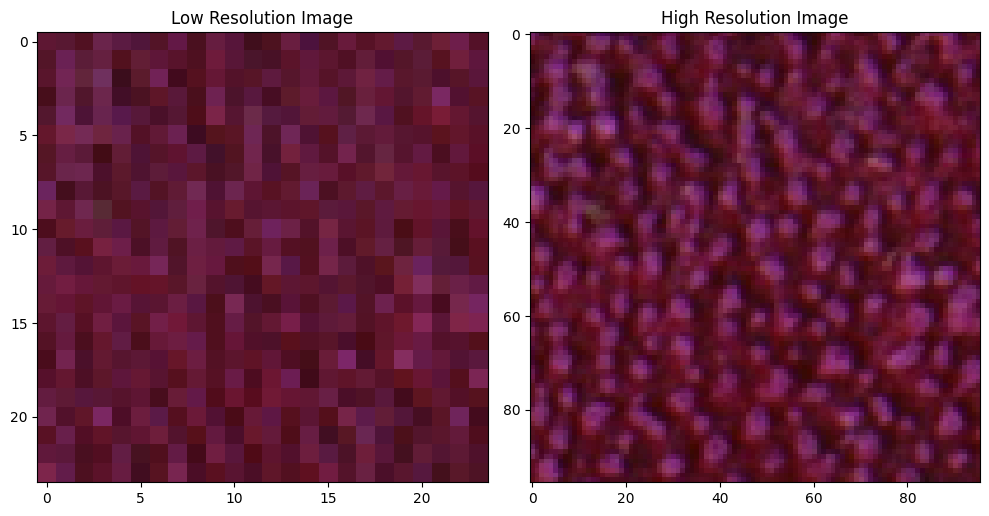

In [4]:
sample_dataset = SRGANTrainingDataset(
    img_dir=r'../data/DIV2K_train_HR',
    sub_img_size=96,
    scale=4,
    subset=1,
)

idx = np.random.randint(0, len(sample_dataset))

sample_lr, sample_hr = sample_dataset[idx]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(sample_lr.permute(1, 2, 0).numpy())
axes[0].set_title('Low Resolution Image')
axes[1].imshow((sample_hr * 0.5 + 0.5).permute(1, 2, 0).numpy())
axes[1].set_title('High Resolution Image')

plt.tight_layout()
plt.show()

# 4 Training

My Modifications:


In [5]:
def train_epoch(model, train_loader, optimizer, criterion, device, writer, epoch, epochs):
    model.train()
    train_loss = 0.0
    bar = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{epochs}', unit='batch')

    step = 0

    for lr, hr in bar:
        lr = lr.to(device, non_blocking=True)
        hr = hr.to(device, non_blocking=True)

        optimizer.zero_grad()

        sr = model(lr)

        loss = criterion(sr, hr)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        if step % 100 == 0:
            writer.add_scalar('Loss/train_batch', loss.item(), epoch * len(train_loader) + step)
            bar.set_description(f'Epoch {epoch + 1}/{epochs} - Loss: {loss.item():.6f}')

        step += 1

    avg_train_loss = train_loss / len(train_loader)
    writer.add_scalar('Loss/train', avg_train_loss, epoch)

    return avg_train_loss

def validate_epoch(model, val_loader, criterion, device, writer, epoch, epochs):
    model.eval()
    val_loss = 0.0

    bar = tqdm(val_loader, desc=f'Validation {epoch + 1}/{epochs}', unit='batch')

    with torch.no_grad():
        for lr, hr in bar:
            lr = lr.to(device, non_blocking=True)
            hr = hr.to(device, non_blocking=True)

            sr = model(lr)

            loss = criterion(sr, hr)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)

    writer.add_scalar('Loss/val', avg_val_loss, epoch)
    bar.set_description(f'Validation {epoch + 1}/{epochs} - Loss: {avg_val_loss:.6f}')

    return avg_val_loss

def train(model, train_loader, val_loader, optimizer, scheduler, criterion, device, log_dir, save_path, epochs):
    writer = SummaryWriter(log_dir=log_dir)

    for epoch in range(epochs):
        train_loss = train_epoch(model, train_loader, optimizer, criterion, device, writer, epoch, epochs)

        val_loss = validate_epoch(model, val_loader, criterion, device, writer, epoch, epochs)

        scheduler.step(val_loss)
        for i, param_group in enumerate(optimizer.param_groups):
            writer.add_scalar(f'Learning Rate/Group {i}', param_group['lr'], epoch)

        torch.save({
            'epoch': epoch + 1,
            'datetime': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
            'loss': {
                'train': train_loss,
                'val': val_loss
            },
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
        }, f'{save_path}_epoch_{epoch + 1}.pt'
        )

    writer.close()

In [6]:
batch_size = 16

train_dataset = SRGANTrainingDataset(img_dir=r'../data/DIV2K_train_HR', sub_img_size=96, scale=4, subset=200)
set5_val_dataset = SRGANValidationDataset(img_dir=r'../data/Set5', scale=4)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
val_set5_loader = DataLoader(set5_val_dataset, batch_size=1, shuffle=False)

srresnet_x4 = SRResNet(in_out_channels=3, hidden_channel=64, kernel_sizes=(9, 3, 9), scale=4).to(cuda_device)

from torch.optim import Adam

srresnet_x4_optim = Adam(
    srresnet_x4.parameters(),
    lr=1e-4,
    betas=(0.9, 0.999),
)

srresnet_x4_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    srresnet_x4_optim,
    mode='min',
    factor=0.5,
    patience=15,
)

mse_loss = torch.nn.MSELoss(reduction='mean')

In [7]:
train(
    model=srresnet_x4,
    train_loader=train_loader,
    val_loader=val_set5_loader,
    optimizer=srresnet_x4_optim,
    scheduler=srresnet_x4_scheduler,
    criterion=mse_loss,
    device=cuda_device,
    log_dir='../runs/srresnet_x4',
    save_path='../models/srresnet_x4/srcnn_x4',
    epochs=5
)

Epoch 1/5:   0%|          | 0/13 [00:00<?, ?batch/s]

c:\Users\yeapj\Downloads\single-image-super-resolution\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Validation 5/5: 100%|██████████| 5/5 [00:02<00:00,  1.69batch/s]


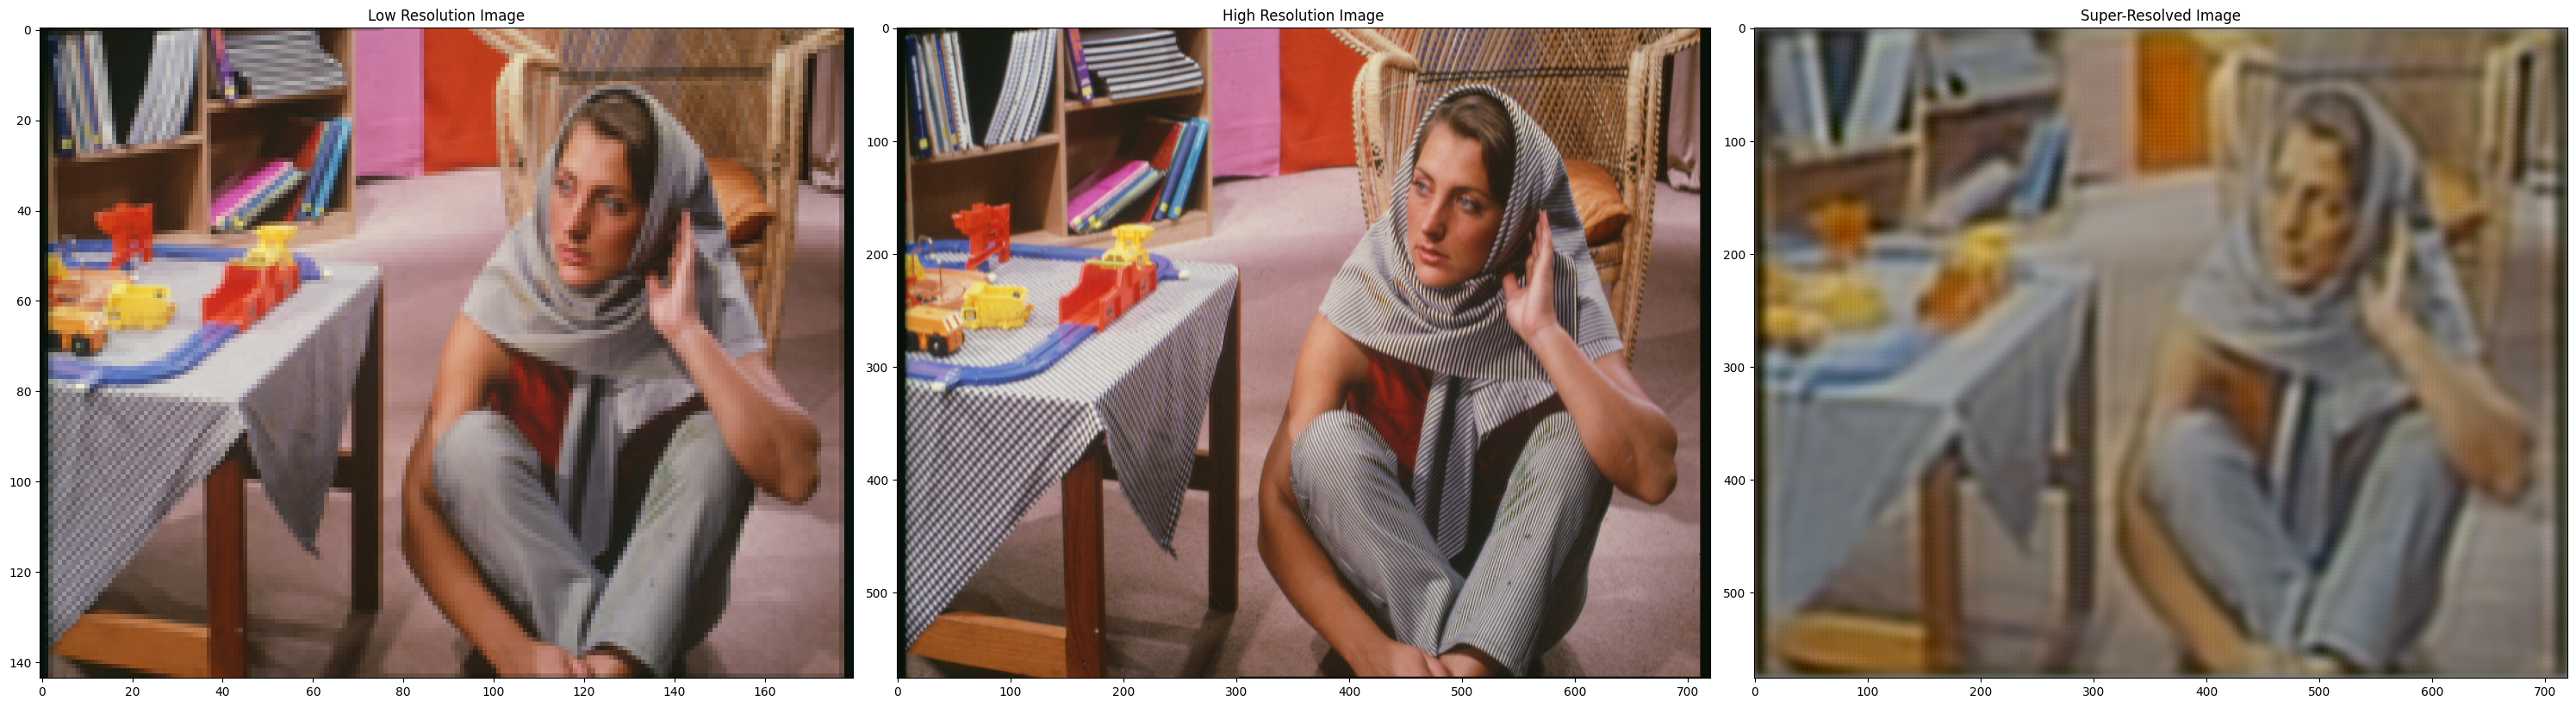

np.float64(17.917832390638)

In [8]:
set14_dataset = SRGANValidationDataset(
    img_dir=r'../data/Set14',
    scale=4
)

idx = np.random.randint(0, len(set14_dataset))

sample_lr, sample_hr = set14_dataset[idx]

srresnet_x4.eval()
with torch.no_grad():
    sr = srresnet_x4(sample_lr.to(cuda_device).unsqueeze(0)).squeeze(0).cpu()

fig, axes = plt.subplots(1, 3, figsize=(30, 15))

axes[0].imshow(sample_lr.permute(1, 2, 0).numpy())
axes[0].set_title('Low Resolution Image')
axes[1].imshow((sample_hr * 0.5 + 0.5).permute(1, 2, 0).numpy())
axes[1].set_title('High Resolution Image')
axes[2].imshow((sr * 0.5 + 0.5).permute(1, 2, 0).cpu().numpy())
axes[2].set_title('Super-Resolved Image')

plt.tight_layout()
plt.show()

psnr((sample_hr * 0.5 + 0.5).permute(1, 2, 0).numpy(), (sr * 0.5 + 0.5).permute(1, 2, 0).numpy(), data_range=1.0)

In [9]:
sr_psnrs = []

for i, (lr, hr) in enumerate(set14_dataset):
    srresnet_x4.eval()

    with torch.no_grad():
        sr = srresnet_x4(lr.to(cuda_device).unsqueeze(0)).squeeze(0).cpu()

    hr = hr[
        :,
        :hr.shape[1] // 4 * 4,
        :hr.shape[2] // 4 * 4
    ]

    sr_psnr = psnr((hr * 0.5 + 0.5).permute(1, 2, 0).numpy(), (sr * 0.5 + 0.5).permute(1, 2, 0).numpy(), data_range=1.0)

    sr_psnrs.append(sr_psnr)

print(f'Average PSNR for Super-Resolved Images: {np.mean(sr_psnrs):.2f} dB')
print('-' * 100)
print(f'Maximum PSNR for Super-Resolved Images: {np.max(sr_psnrs):.2f} dB')
print('-' * 100)
print(f'Minimum PSNR for Super-Resolved Images: {np.min(sr_psnrs):.2f} dB')

Average PSNR for Super-Resolved Images: 16.50 dB
----------------------------------------------------------------------------------------------------
Maximum PSNR for Super-Resolved Images: 18.21 dB
----------------------------------------------------------------------------------------------------
Minimum PSNR for Super-Resolved Images: 11.73 dB


In [10]:
sr_psnrs

[np.float64(16.053050591140487),
 np.float64(17.917832390638),
 np.float64(17.429375403662977),
 np.float64(17.345308436561112),
 np.float64(14.647081488200513),
 np.float64(17.461669766360014),
 np.float64(16.56053123242514),
 np.float64(14.853601157685931),
 np.float64(17.22321071258716),
 np.float64(18.211487660283986),
 np.float64(18.088609163307467),
 np.float64(17.236151939304094),
 np.float64(11.725309375315353),
 np.float64(16.235564573538003)]